# Dimensionnement d'un système photovoltaïque en autoconsommation


*Ce Jupyter Notebook a été développé dans le cadre d'un séminaire à l'École Nationale Supérieure d'Architecture de Grenoble (ENSAG) avec les outils NoLOAD version 1.0.3 et le benchmark NoLOAD version 1.0.0*  
*L'identifiant ci-dessous [SPDX](https://spdx.dev/) renseigne la license ([Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html)) et les détenteurs du copyright :*  
- *SPDX-FileCopyrightText: 2020 G2Elab / MAGE*  
- *SPDX-License-Identifier: Apache-2.0*  

>***Vous utilisez un Jupyter Notebook pour la première fois ?*** Afin d'utiliser ce fichier en ligne avec le service public Mybinder, cliquez sur le lien suivant :  
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fdesign_optimization%2Fnoload_benchmarks_open/HEAD?filepath=%2Fexamples%2Fpv_battery_coverage_gwp%2Fdimensionnement_PV_ENSAG.ipynb)  
>Vous pouvez ensuite facilement utiliser ce notebook en exécutant chaque cellule avec l'icône Run (Exécuter) dans la barre d'outils en haut de la page. Lorsque l'icône orange du cahier dans l'onglet internet se transforme en sablier, cela signifie que le code est en cours d'exécution. N'hésitez pas à modifier et à adapter le code, le travail avec Mybinder crée une copie en ligne du fichier original.

## Objectif du notebook

L'objectif de ce notebook est de présenter un processus de modélisation énergétique ouverte, sur un cas d'autoconsommation photovltaïque à l'échelle d'un bâtiment. Les données et outils pourront directement être utilisés en ligne.

![autoconso](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/raw/master/examples/pv_battery_coverage_gwp/figures/autoconsommation_PV.png)

Pour rentrer dans le détail, le cas d'étude est celui d'un logement en autoconsommation d'énergie photovoltaïque (PV) avec stockage sur batterie. 
L'augmentation de la part des énergies renouvelables dans notre consommation énergétique ainsi que l'amélioration de l'efficacité énergétique et la réduction de notre consommation énergétique totale ont été identifiées comme les principales solutions pour une transition énergétique viable.  
L'autoconsommation PV peut réduire l'impact du PV sur le réseau électrique et ainsi améliorer ldéploiement de solutions photovltaïques. 

Dans ce cas d'étude, nous nous intersserons au **dimensionnement de panneaux photovoltaïques et batteries associées**, mais aussi à la question de l'**impact environnemental** de l'autoconsommation PV.  
Nous nous concentrerons ici uniquement sur le potentiel de réchauffement global (GWP pour Global Warming Potential en kg CO2 équivalent) du système énergétique sur l'ensemble de son cycle de vie.  

En bref, voici le contenu de ce notebook :
1. Import et gestion des données d'entrées : les profils d'ensoleillement, et les profils de consommation électrique pour un foyer grenoblois
2. Extraction de 3 journées représentatives de l'année pour l'ensoleillement et la consommation.
3. Utilisation d'un modèle panneau photovoltaïque pour passer de l'ensoleillement, à la production d'électricité PV
4. Calcul de l'impact environnemental de ce système avec l'indicateur GWP
5. Optimisation du dimensionnement des panneaux et batteries selon des critères énergétiques ou environnementaux
6. Limites et discussion

### Test exécution de code
Un petit test pour vérifier que tout fonctionne. Dans la cellule ci-dessous, entrez ce que vous voulez après message = ... (en conservant les guillemets, puis exécutez la cellule. Votre message devrait s'afficher :)

In [68]:
message = "Ceci est un message test"
print(message)

Ceci est un message test


## 1. Données d'entrée et hypothèses de modélisation

Il est important d'être transparent sur les hypothèses de modélisation qui ont été faites, ainsi que sur les données d'entrée et leur provenance. Cela afin de bien comprendre les résultats que l'on obtiendra, mais aussi leurs limites.

### Profils d'ensoleillement et consommation du foyer
On peut bien sûr choisir et modifier les profils d'ensoleillement et de consommation selon le cas spécifique du lieu et conditions dans lesquelles on se trouve. Ici, nous prenons le cas d'un ensoleillement à Grenoble grâce à la [station météo](https://ense3.grenoble-inp.fr/fr/l-ecole/station-meteo-green-er) située sur le toit du bâtiment GreEn-ER. 

![Carte_Grenoble](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/raw/master/examples/pv_battery_coverage_gwp/figures/Carte_Grenoble.png)
*Crédit image OpenStreetMap France - licence libre CC-BY-SA*

Entre autres valeurs, elle permet notamment de mesurer :
- **L'irradiance directe** : c'est le rayonnement solaire reçu par une surface orientée perpendiculairement aux rayons du soleil, mesuré en Watt par m², donc l'énergie, reçue pendant une heure, sur une surface de 1 m² perpendiculaire au rayonnement solaire. Il exclut le rayonnement solaire diffus. L'irradiance directe est égale à l'irradiance au-dessus de l'atmosphère moins les pertes atmosphériques. On parle de *DNI* pour Direct Normal Irradiation
- **Le rayonnement solaire diffus** : c'est le rayonnement à la surface de la Terre provenant de la lumière diffusée par l'atmosphère. Il est mesuré sur une surface horizontale avec le rayonnement provenant de tous les points du ciel, à l'exclusion du rayonnement provenant du disque solaire. On parle de *DHI* pour Diffuse Horizontal Irradiance.

![DHI_DNI](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/raw/master/examples/pv_battery_coverage_gwp/figures/DHI_DNI.png)

Les profils de consommation sont basés sur des données moyennes de foyers en français.

#### Import de bibliothèques
Avant de commencer, il est nécessaire d'importer certaines "bibliothèques", c'est à dire des répertoires de codes que l'on va utiliser par la suite. Par exemple, numpy et pandas permettent de traiter les données.  
Ici, il faut simplement exécuter la fenêtre de code ci-dessous, qui va importer les bibliothèques pertinentes.

In [69]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import models.solarPV as solarPV
from data.data_management import read_data, load_consumption_index, load_irradiance_index, extract_csv_from_mhi, get_data

#### Données d'ensoleillement 
Comme indiqué plus haut, les données d'ensoleillement proviennent de la station météo du bâtiment GreEn-Er (bâtiment hébergeant le laboratoire de génie électrique de Grenoble - G2Elab ; et l'école d'ingénieur ENSE3), décrite sur cette   [page internet](https://ense3.grenoble-inp.fr/fr/l-ecole/station-meteo-green-e) . On peut si on le souhaite, directement observer les données via l'[interface Grafana](https://mhi-srv.g2elab.grenoble-inp.fr/grafana/d/VnkHFo6mk/dashboard). Ces données sont [mises à disposition sur un serveur sous la licence publique *Public Domain Dedication and License version v1.0*](http://mhi-srv.g2elab.grenoble-inp.fr/API/).  

Pour ce cas d'étude, on va directement utiliser les données du fichier [*irradiance_data.csv*](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/blob/master/examples/pv_battery_coverage_gwp/data/irradiance_data.csv), c'est un tableur où ont les données d'ensoleillement du serveur ont été directement importées, sans traitement. On peut les observer en exécutant la cellule ci-dessous.

In [70]:
file_name = ('./data/irradiance_data.csv')
raw_irradiance_data = pd.read_csv(file_name, sep=';', decimal=".") 
print(raw_irradiance_data)

                              Unnamed: 0  sun_diffus  sun_direct
0              2019-01-01 00:00:00+00:00       0.560       0.000
1              2019-01-01 01:00:00+00:00       0.571       0.000
2              2019-01-01 02:00:00+00:00       0.431       0.000
3              2019-01-01 03:00:00+00:00       0.540       0.000
4              2019-01-01 04:00:00+00:00       0.559       0.000
5              2019-01-01 05:00:00+00:00       0.518       0.000
6              2019-01-01 06:00:00+00:00       0.537       0.000
7              2019-01-01 07:00:00+00:00       0.602       0.000
8              2019-01-01 08:00:00+00:00       1.204       0.390
9              2019-01-01 09:00:00+00:00      20.510       0.315
10             2019-01-01 10:00:00+00:00      46.690       0.047
11             2019-01-01 11:00:00+00:00      73.850       0.001
12             2019-01-01 12:00:00+00:00      95.600       0.000
13             2019-01-01 13:00:00+00:00      65.560       0.005
14             2019-01-01

On voit que les données brutes sont difficiles à comprendre : nous allons donc rajouter des en-têtes, et remettre les données au pas de temps horaire avec la cellule ci-dessous.

In [71]:
# Renaming headers
raw_irradiance_data_head = pd.DataFrame({        
        'TIMESTAMP':raw_irradiance_data.iloc[:,0],
        'DHI': raw_irradiance_data['sun_diffus'],
        'DNI': raw_irradiance_data['sun_direct'],        
    }, index=raw_irradiance_data.index)       

# Setting TIMESTAMP index with proper datetime format
raw_irradiance_data_head['TIMESTAMP'] = pd.to_datetime(raw_irradiance_data_head['TIMESTAMP'])
raw_irradiance_data_head.set_index('TIMESTAMP',inplace=True)

# Resampling with mean function to get hourly data
hourly_irradiance_data = raw_irradiance_data_head.resample('H').mean()
print(hourly_irradiance_data)

                            DHI         DNI
TIMESTAMP                                  
2019-01-01 00:00:00    0.560000    0.000000
2019-01-01 01:00:00    0.571000    0.000000
2019-01-01 02:00:00    0.431000    0.000000
2019-01-01 03:00:00    0.540000    0.000000
2019-01-01 04:00:00    0.559000    0.000000
2019-01-01 05:00:00    0.518000    0.000000
2019-01-01 06:00:00    0.537000    0.000000
2019-01-01 07:00:00    0.602000    0.000000
2019-01-01 08:00:00    1.204000    0.390000
2019-01-01 09:00:00   20.510000    0.315000
2019-01-01 10:00:00   46.690000    0.047000
2019-01-01 11:00:00   73.850000    0.001000
2019-01-01 12:00:00   95.600000    0.000000
2019-01-01 13:00:00   65.560000    0.005000
2019-01-01 14:00:00   37.660000    0.027000
2019-01-01 15:00:00   17.700000    0.240000
2019-01-01 16:00:00    5.721000    0.499000
2019-01-01 17:00:00    0.679000    0.002000
2019-01-01 18:00:00    0.567000    0.000000
2019-01-01 19:00:00    0.536000    0.000000
2019-01-01 20:00:00    0.379000 

On va ensuite s'assurer qu'il n'y a pas d'erreur dans nos jeux de données. Les erreurs dans les jeux de données sont généralement indiquées par l'abréviation NaN qui signifie *Not a Number*. Regardons ça avec la cellule ci-dessous :

In [72]:
# Finding potential errors - NaN
hourly_irradiance_data[hourly_irradiance_data.isnull().any(axis=1)]

DHI  DNI
TIMESTAMP                    
2019-02-20 11:00:00  NaN  NaN
2019-02-21 11:00:00  NaN  NaN

Dans la version actuelle, certaines lignes ont la valeur "Not a Number", en raison d'un changement de matériel sur la station météo début 2019.  
La base de données étant actuellement mise à jour, les profils d'irradiance ont été corrigés localement et inclus dans le fichier *csv irradiance_and_consumption_data* importé dans la section suivante [Gestion des données à partir du fichier csv](#data-management-from-csv-file).

#### Profil de consommation
Les profils de consommation sont obtenus à partir de profils de consommation électrique provenant d'Enedis, le gestionnaire du réseau de distribution électrique en France : [Profil RES1](https://www.enedis.fr/coefficients-des-profils "Profils RES1 sur le site d'Enedis"). Ce sont des des profils de consommation typiques pour les bâtiments domestiques (appartement, maison individuelle, ...). Ces profils de consommation sont partagés avec la [Licence ouverte v2.0 (Etalab)](https://www.etalab.gouv.fr/wp-content/uploads/2018/11/open-licence.pdf). Nous considérons une consommation annuelle de 4586 kWh par an et par logement, calculée à partir du nombre de foyers raccordés au système électrique français selon ce [rapport de la Commission de Régulation de l'Énergie (CRE)](https://www.cre.fr/Documents/Publications/Rapports-thematiques/Etat-des-lieux-des-marches-de-detail-de-l-electricite-et-du-gaz-naturel-en-2017), page 19 (32,4 millions de consommateurs résidentiels raccordés en 2017), et de la consommation finale d'électricité du secteur résidentiel français de [148,6 TWh en 2019](https://opendata.reseaux-energies.fr/explore/dataset/consommation-annuelle-nette-typologie/table/?disjunctive.segment&sort=annee).  

<a id='data-management-from-csv-file'></a>
#### Gestion des données à partir d'un fichier csv
Comme précisé, une version locale des jeux de données est disponible. Elle est importée avec la fonction *read_data*. La consommation typique d'un foyer est adaptée au profil partagés par Enedis. On aboutit à la consommation annuelle suivante:

In [73]:
# Data
yearly_data = read_data(file_name='./data/irradiance_and_consumption_data.csv')
yearly_irradiance = yearly_data[0]
yearly_consumption = yearly_data[1].values[:, 0]
print("""Consommation annuelle d'un foyer= {} kWh""".format(round(sum(yearly_consumption)/1e3)))

Consommation annuelle d'un foyer= 4453 kWh


## 2. Extraire des journées types : le clustering

Pour faciliter le dimensionnement et le traitement de ce cas d'étude, on va essayer de trouver des "jours typiques" d'ensoleillement et de consommation électrique. Pour ce faire, on utilise un algorithme appelé *Clustering*.   
Le clustering permet de rassembler entre eux des groupes de données ressemblantes. On prendra ensuite les valeurs moyennes d'ensoleillement et de consommation électrique dans chacun de ces groupes de données ressemblantes, afin d'obtenir nos jours représentatifs.  
  
Ci-dessous, l'algorithme de clustering est exécuté. La première figure affiche les profils de consommation (*Consumption profiles (W)*) et d'ensoleillement (*DHI* et *DNI* en W/m²) pour chacun des 356 jours de l'année.  
La seconde figure affiche les résultats du clustering, c'est à dire les consommation, DHI et DNI pour les 3 jours typiques qui ont été obtenus.

c:\python3.6.0\lib\site-packages\scipy\cluster\vq.py:139: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  RuntimeWarning)


Number of days in each cluster
[135 180  50]
Indices of days close to the cluster center
[330 240   3]


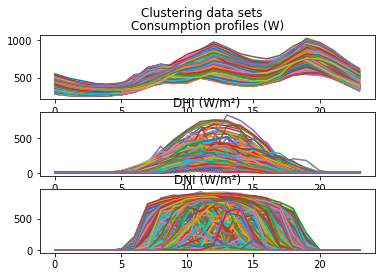

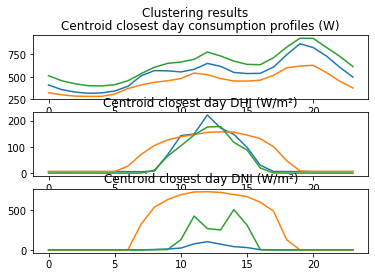

(array([135, 180,  50], dtype=int64), array([330, 240,   3], dtype=int64))

In [74]:
# Clustering
from data.clustering import clustering
clustering('./data/irradiance_and_consumption_data.csv', 3, True)

A partir de ces résultats, on observe que les jours typiques obtenus sont les 3ème, 240ème et 330ème de l'année, soit le 4 janvier, le 29 août et le 27 Novembre. On reconnaît des jours typiques d'hiver, d'été, et de mi-saison.  

Si on souhaite à afficher les valeurs d'ensoleillement et de consommation pour ces jours types, on peut utiliser la cellule ci-dessous pour tracer des courbes

Text(0, 0.5, 'DNI (W/m²)')

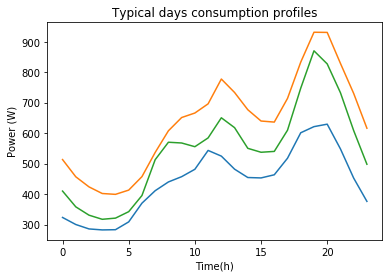

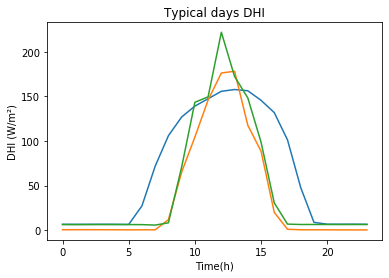

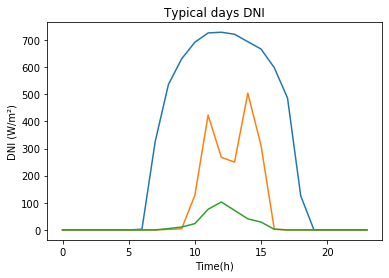

In [75]:
import matplotlib.pyplot as plt

summer_consumption = [yearly_consumption[h] for h in range(24*240,24*241)]
winter_consumption = [yearly_consumption[h] for h in range(24*3,24*4)]
mid_consumption = [yearly_consumption[h] for h in range(24*330,24*331)]

summer_irradiance = yearly_irradiance.iloc[24*240:24*241]
winter_irradiance = yearly_irradiance.iloc[24*3:24*4]
mid_irradiance = yearly_irradiance.iloc[24*330:24*331]

# Plotting these figures ?

plt.figure(0)
plt.plot(summer_consumption)
plt.plot(winter_consumption)
plt.plot(mid_consumption)
plt.title('Typical days consumption profiles')
plt.xlabel('Time(h)')
plt.ylabel('Power (W)')

plt.figure(1)
plt.plot(summer_irradiance['DHI'].values)
plt.plot(winter_irradiance['DHI'].values)
plt.plot(mid_irradiance['DHI'].values)
plt.title('Typical days DHI')
plt.xlabel('Time(h)')
plt.ylabel('DHI (W/m²)')

plt.figure(2)
plt.plot(summer_irradiance['DNI'].values)
plt.plot(winter_irradiance['DNI'].values)
plt.plot(mid_irradiance['DNI'].values)
plt.title('Typical days DNI')
plt.xlabel('Time(h)')
plt.ylabel('DNI (W/m²)')


<span style="color:red"> ***TODO***</span> : interprétez ces courbes, et notamment la première affichant les consommations électriques pour 3 jours types. Comment expliquer cette évolution ? 

## 3. De l'ensoleillement à la production PV : le modèle énergétique

Le modèle énergétique est simplifié, les principales variables et paramètres sont les suivants :
- pv_power (W): la puissance produite par les panneaux photovoltaïques en fonction des valeurs d'ensoleillement (W/m²) ainsi que de l'inclinaison (degrés), de l'orientation (degrés) et de la surface (m²) des panneaux. Elle est définie dans le modèle solarPV.
- consumption (W): la consommation du foyer
- e_sto (Wh): l'énergie dans la batterie
- import (Wh): l'énergie importée depuis le réseau électrique
- export (Wh): l'énergie exportée sur le réseau électrique

![PV self cons](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/raw/master/examples/pv_battery_coverage_gwp/figures/dwelling_pv_self_consumption.png)

Les imports, exports, la puissance PV et la consommation sont illustrés via les calculs ci-dessous (sans prise en compte de la batterie).

On commence par définir :
- l'inclinaison (*tilt* en anglais) : 0° à l'horizontal, 90° à la verticale
- l'orientation (*azimuth* en anglais) : une valeur de 0 donne plein sud, -90 l'ouest et +90 l'est, 180 au Nord
- la surface (*surface* en anglais ;) )

<span style="color:red"> ***TODO***</span> : n'hésitez pas à tester différents dimensionnement en modifiant les valeurs de ces paramètres et ré-exécutant cette cellule, puis la suite du code de calcul.

In [76]:
# A PV power profile example...
tilt = 25
azimuth = 0
surface = 8

*NB : Pour toute l'étude, les valeurs d'inclinaison et d'orientation sont constantes : les panneaux sont fixes.*

Les cellules suivantes permettent d'observer la production PV fonction de l'ensoleillement et des paramètres donnés ci-dessus, ainsi que la consommation. On peut ainsi observer pour chaque jour:
- l'électricité injectée sur le réseau (en rouge)
- l'électricité importée depuis le réseau (en jaune)
- l'électricité autoconsommée (en blanc)

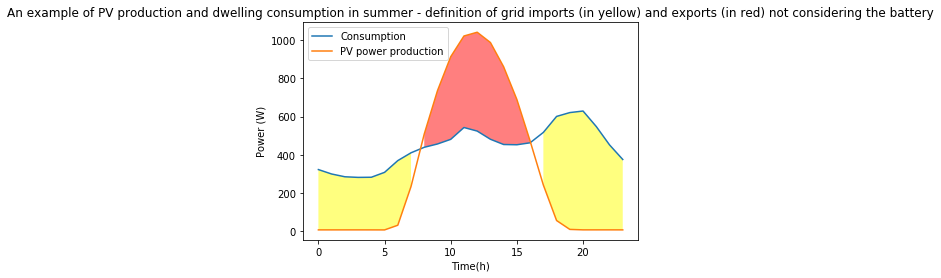

In [77]:
# Le 29 Août
solar_summer = solarPV.PVSolar(summer_irradiance.index.to_series())
DNI_summer = np.array(summer_irradiance['DNI'])
DHI_summer = np.array(summer_irradiance['DHI'])

pv_power_summer = solar_summer.pv_power(tilt, azimuth, surface, DNI_summer, 
                                        DHI_summer)

# Tracé de la figure
fig2, ax2 = plt.subplots()  
ax2.plot(summer_consumption, label='Consumption') 
ax2.plot(pv_power_summer, label='PV power production') 

plt.fill_between(np.arange(0,24), pv_power_summer, summer_consumption, 
                 where=summer_consumption >= pv_power_summer, 
                 facecolor='yellow', alpha=0.5)
plt.fill_between(np.arange(0,24), pv_power_summer, summer_consumption, 
                 where=pv_power_summer >= summer_consumption, facecolor='red', alpha=0.5)
ax2.set_xlabel('Time(h)')  
ax2.set_ylabel('Power (W)')  
ax2.set_title('An example of PV production and dwelling consumption '
              'in summer - '
              'definition of grid imports (in yellow) and exports (in red) not considering the battery')
ax2.legend()  

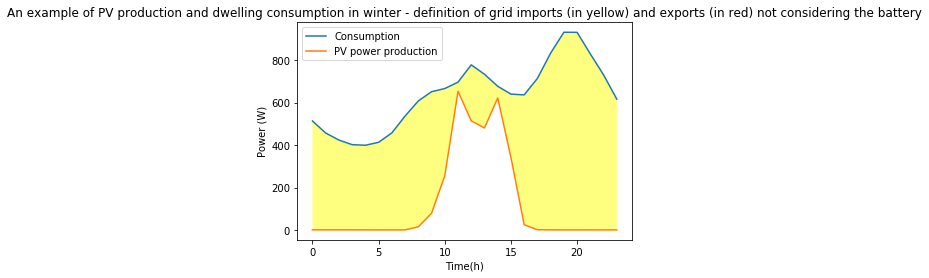

In [78]:
# En janvier
solar_winter = solarPV.PVSolar(winter_irradiance.index.to_series())
DNI_winter = np.array(winter_irradiance['DNI'])
DHI_winter = np.array(winter_irradiance['DHI'])
pv_power_winter = solar_winter.pv_power(tilt, azimuth, surface, DNI_winter, 
                                        DHI_winter)
# Tracé de la figure
fig3, ax3 = plt.subplots()  
ax3.plot(winter_consumption, label='Consumption') 
ax3.plot(pv_power_winter, label='PV power production') 
plt.fill_between(np.arange(0,24), pv_power_winter, winter_consumption, 
                 where=winter_consumption >= pv_power_winter, 
                 facecolor='yellow', alpha=0.5)
plt.fill_between(np.arange(0,24), pv_power_winter, winter_consumption, 
                 where=pv_power_winter >= winter_consumption, facecolor='red', 
                 alpha=0.5)
ax3.set_xlabel('Time(h)')  
ax3.set_ylabel('Power (W)')  
ax3.set_title('An example of PV production and dwelling consumption '
              'in winter - '
              'definition of grid imports (in yellow) and exports (in red) not considering the battery')
ax3.legend()  

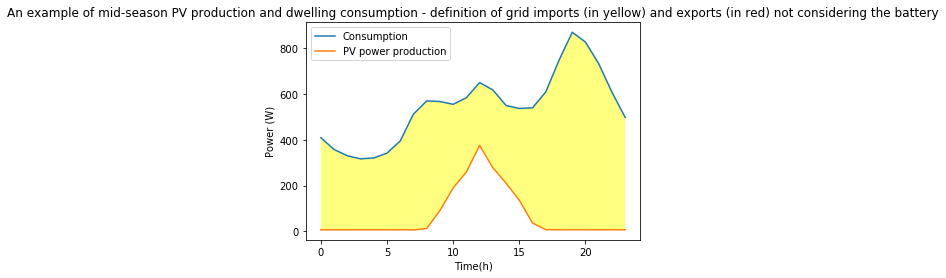

In [79]:
# En Novembre
solar_mid = solarPV.PVSolar(mid_irradiance.index.to_series())
DNI_mid = np.array(mid_irradiance['DNI'])
DHI_mid = np.array(mid_irradiance['DHI'])
pv_power_mid = solar_winter.pv_power(tilt, azimuth, surface, DNI_mid, 
                                        DHI_mid)
# Tracé de la figure
fig3, ax3 = plt.subplots()  
ax3.plot(mid_consumption, label='Consumption') 
ax3.plot(pv_power_mid, label='PV power production') 
plt.fill_between(np.arange(0,24), pv_power_mid, mid_consumption, 
                 where=mid_consumption >= pv_power_mid, 
                 facecolor='yellow', alpha=0.5)
plt.fill_between(np.arange(0,24), pv_power_mid, mid_consumption, 
                 where=pv_power_mid >= mid_consumption, facecolor='red', 
                 alpha=0.5)
ax3.set_xlabel('Time(h)')  
ax3.set_ylabel('Power (W)')  
ax3.set_title('An example of mid-season PV production and dwelling consumption - '             
              'definition of grid imports (in yellow) and exports (in red) not considering the battery')
ax3.legend()  

On va ensuite renseigner les paramètres de la batterie : son énergie e_sto, et son efficacité à la charge et à la décharge. La batterie choisie ici est une batterie plomb, il s'agit des batteries utilisées dans les voitures thermiques.

In [80]:
e_sto = 1000  # value for the stored energy (Wh)
eff_sto_lead_acid = 0.75  # efficacity of the lead-acid battery

Enfin, on peut définir un objectif d'optimisation, à savoir le **taux d'autconsommation** (Supply Cover Factor (*SCF*) en anglais). Le taux d’autoconsommation, c'est la part d’électricité PV consommée localement (aire blanche sous la courbe orange et/ou bleue), par rapport à la totalité de l’électricité produite par les panneaux PV (aire totale sous la courbe orange). La part restante, le surplus, est réinjectée sur le réseau public d’électricité.

$$ autoconsommation \;(ou  SCF)= \frac{Consommation électrique - imports}{Électricité PV} $$  

On peut remarquer que l'aire blanche sous la courbe orange et/ou bleue, soit la consommation locale d'électricité PV correspond aussi bien à :
- la production PV à laquelle on soustrait les exports
- la consommation à laquelle on soustrait les imports

Enfin les batteries vont permettre de stocker de l'énergie PV pour la délivrer à un moment où la consommation dépasse la production PV. C'est à dire : déplacer des blocs d'énergie produite localement pour remplacer des imports depuis le réseau électrique. Cet élément pourra être explorer dans un Notebook complémentaire. 

On peut calculer ce SCF avec les valeurs pour les panneaux et les batteries indiquées précédemment:

In [81]:
e_balance_vect = pv_power_summer - summer_consumption

# Defining energy import & export, depending on hourly balance, 
# and the total battery energy charged/discharged, taking into 
# account the storage efficiency.
energy_import = -np.sum(e_balance_vect[e_balance_vect < 0]) \
                - eff_sto_lead_acid * e_sto
energy_export = np.sum(e_balance_vect[e_balance_vect > 0]) \
                - eff_sto_lead_acid * e_sto

pv_supply = pv_power_summer.sum()  # PV energy
load = sum(summer_consumption)  # Load energy
e_balance = np.sum(e_balance_vect)
coverage = pv_supply - energy_export
# checking the definition with another one :
coverage2 = load - energy_import
assert (abs(coverage - coverage2) < 1e-5)
# defining the cover factors, between 1 and 0 :
supply_cover_factor = coverage / pv_supply
load_cover_factor = coverage / load

print('The supply cover factor is {0} for this example.'.format(round(supply_cover_factor, 2)))

The supply cover factor is 0.72 for this example.


<span style="color:red"> ***TODO***</span> : à votre avis, à quel jour type correspond ce taux d'autoconsommation ? Pourquoi ?

## 4. Étude des impacts environnementaux 
Pour étudier les impact environnementaux de notre système, on doit s'intéresser à son cycle de vie complet. On appelle cycle de vie les étapes dans la vie d'un objet, depuis l'extraction des matières premières jusqu'à la fin de vie, en passant par la phase d'usage.

![Cycle_de_vie_PV](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/raw/master/examples/pv_battery_coverage_gwp/figures/Cycle_de_vie_PV.png)

*Cycle de vie d'un panneau PV. Source : thèse Nouha Gazbour*  


Pour faire l'étude du cycle de vie d'un objet (on parle d'Analyse de Cycle de Vie, ou ACV), on doit définir une unité fonctionnelle, c'est à dire le service que rend l'objet. 
Ici notre **unité fonctionnelle** sera : *consommer de l'électricité selon une consommation donnée de 4586 kWh par an pendant 30 ans, depuis le réseau électrique et un système de panneaux PV et batteries*.  

Pour l'ACV, on peut s'intéresser à différents indicateurs environnementaux (consommation d'eau, de ressources fossiles, toxicité, ...). Ici, l'étude des impacts environnementaux se concentre sur l'indicateur de Potentiel de réchauffement global (Global Warming Potential (*GWP*) en anglais)(eq kgCO2), qui rend compte de l'impact des émissions de Gaz à Effet de serre sur le réchauffement climatique.

Toutes les valeurs présentées proviennent de bases de données ouvertes issues de données ministérielles, pour le  [PV mono-crystallin](https://www.base-inies.fr/iniesV4/dist/consultation.html?id=8519) et les [batteries plom](https://www.base-inies.fr/iniesV4/dist/consultation.html?id=5638). Les émissions de CO2 du réseau électrique français proviennent de la [base de donnée de l'ADEME](http://bilans-ges.ademe.fr/) et sont basées sur la consommation moyenne de 2018. Les émissions du réseau électrique européen sont elles basée sur le [site de l'Agence Environnementale Européenne (EEA)](https://www.eea.europa.eu/data-and-maps/daviz/co2-emission-intensity-5#tab-googlechartid_chart_11_filters=%7B%22rowFilters%22%3A%7B%7D%3B%22columnFilters%22%3A%7B%22pre_config_ugeo%22%3A%5B%22European%20Union%20(current%20composition)%22%5D%7D%7D).  

La cellule ci-dessous permet d'indiquer les valeurs des émissions de gaz à effet de serre pour chaque élément du système énergétique : panneaux PV, batteries, réseau, ...

In [82]:
pv_gwp_raw = 4738.2  # for 6.67m² - 1kWp, monocristalline silicon 30 years lifespan
battery_gwp_raw = 351  # Lead-acid battery [capacity=200Ah], 38.6kg
battery_lifespan = 3  # Lead-acid battery lifespan
dod_lead_acid = 0.5  #depth of discharge lead-acid = 50%
# french electricity mix, consumption mean value, http://bilans-ges.ademe.fr/ 2018
french_power_grid_emissions = 0.0571  # (kgCO2eq / kWh) 
# european electricity mix, data from EEA 2017
european_power_grid_emissions = 0.296

study_time = 30  # years

# Applying coefficients to abide by the functional unit
pv_gwp = pv_gwp_raw / 6.67 * 1  # 1kWp => 1 m² , 30 years
battery_gwp = battery_gwp_raw / (200 * 12) * study_time/battery_lifespan  # 200Ah, 12V, 3 years => 1000 Wh, 30 years

Le potentiel de réchauffement global (GWP en kilogramme équivalents de CO2) du système est alors la somme des émissions sur tout le cycle de vie des :
- panneaux PV
- batteries
- réseau électrique

Ca donne le joli calcul ci-dessous :

$$ GWP\;(kg CO_2 eq)= GWP_{PV}\;(kg CO_2 eq/m²) * area_{PV}\;(m²) + GWP_{battery}\;(kg CO_2 eq/Wh) * capacity\:battery\;(Wh)+ French\:power\:grid\:emissions\:(kg CO_2 eq/kWh) * import\:grid\;(kWh\:over\:a\:year) * study\:time\ (years) $$  

Les GWP des batteries et panneaux PV prennent en compte leur durée de vie, et donc leur remplacement potentiel sur 30 ans.  

Un exemple de calcul de ce GWP avec les paramètres précédents :

In [83]:
sum_nrj_balance_vect = pv_power_winter - summer_consumption
win_nrj_balance_vect = pv_power_winter - winter_consumption
mid_nrj_balance_vect = pv_power_mid - mid_consumption

# daily energy imports
sum_nrj_import = -np.sum(sum_nrj_balance_vect[sum_nrj_balance_vect < 0]) - e_sto
win_nrj_import = -np.sum(win_nrj_balance_vect[win_nrj_balance_vect < 0]) - e_sto
mid_nrj_import = -np.sum(mid_nrj_balance_vect[mid_nrj_balance_vect < 0]) - e_sto

capa_bat = e_sto / dod_lead_acid 
# weight of typical days: 
typical_day_nb = 3
typical_day_weight = [50, 180, 135]
typical_day_indice = [3, 240, 330]
import_list = [win_nrj_import, sum_nrj_import, mid_nrj_import]

# electricity imported from the grid over a year (kWh) 
grid_import = 0
for d in range(0, typical_day_nb):
    grid_import += typical_day_weight[d] * (import_list[d]) * 0.001  # kWh

GWP = pv_gwp * surface + battery_gwp * capa_bat + european_power_grid_emissions * grid_import * study_time
print('Global Warming Potential = {0} eq kg CO2 for an energy import of {1} kWh/year over 30 years'.format(round(GWP,2), round(grid_import,2)))

Global Warming Potential = 37038.7 eq kg CO2 for an energy import of 3201.66 kWh/year over 30 years


<span style="color:red"> ***TODO***</span> : dans la cellule ci-dessus, essayez de faire le calcul de GWP avec les émissions de gaz à effet de serre du réseau électrique français à la place de la moyenne européenne. Qu'est-ce que ça change, et à votre avis, pourquoi ?

## 5. Dimensionnement avec l'outil d'optimisation

Jusqu'ici, nous avons réalisé de la **simulation**, dans le sens où nous indiquions des paramètres (la urface, orientation & inclinaison des panneaux PV, et taille de la batterie). 

Nous allons maintenant réaliser une **optimisation** : cela va consister à indiquer un objectif (par exemple minimiser les émissions de gaz à effet de serre), et des contraintes (par exemple la taille du toit, surface que les panneaux PV ne pourrons pas dépasser). Tout cela dans le but de dimensionner notre système en fonction de nos objectifs & contraintes : concrètement, trouver la taille "optimale" des panneaux et batteries.

### Définition du problème d'optimisation

Pour définir le problème d'optimisation (c'est comme cela qu'on appelle l'assemblage de contraintes et objectif), on va commencer par définir la consommation et l'ensoleillement, comme précédemment.    

Ensuite, on va définir les variables d'optimisation : ce sont les valeurs que l'on explore et que l'on cherche à optimiser. Ici, il s'agit : 
- Pour les panneaux PV :
  - *surface* : on la contraint entre 1 et 21 m²
  - inclinaison (*tilt*)
  - orientation (*azimuth*)
- L'énergie que peut stocker la batterie : on la contraint à 1 kWh (une grosse batterie de voiture)

In [84]:
cons_list = load_consumption_index(
            './data/irradiance_and_consumption_data.csv', typical_day_indice)
irr_list = load_irradiance_index(
            './data/irradiance_and_consumption_data.csv', typical_day_indice)

# creating parameters required for the model computation :
inputs = {'irradiance_list': irr_list,
          'consumption_list': cons_list,
          'typical_day_nb': typical_day_nb,
          'typical_day_weight': typical_day_weight}

# defining optimisation variables
x_names = ['surface', 'tilt', 'azimuth', 'e_sto_1', 'e_sto_2',
                   'e_sto_3']  # variables to optimize

# defining optimisation bounds
e_sto_max = 1000*dod_lead_acid  # capacity below 5 kWh
pv_area_min = 1  # PV area above 1 m²
pv_area_max = 21  # PV area below 21 m²
bounds = [[pv_area_min, pv_area_max], [0, 90], [-80, 80], [0, e_sto_max],
          [0, e_sto_max], [0, e_sto_max]]

# initial values
e_sto_0_value = 500  # initial capacity value
pv_area_0 = 15
tilt_0 = 45
azimuth_0 = 0
x0 = [pv_area_0, tilt_0, azimuth_0, e_sto_0_value, e_sto_0_value,
      e_sto_0_value]

Le problème d'optimisation est créé avec l'outil [**NoLOAD**](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload).  

La dernière étape avant de lancer l'optimisation, est de choisir l'objectif. L'objectif est la valeur que l'algorithme va chercher à minimiser. On peut chosir parmi deux possibilité :
- minimiser les émissions de gaz à effet de serre : c'est l'objectif '***gwp***'
- maximiser le taux d'autoconsommation, ou SCF : puisque l'objectif est minimisé, il s'agira ici de  l'objectif '***non_scf***' qui correspond à *1-SCF*.

In [85]:
objectives = ['gwp']

La cellule ci-dessous permet de définir le problème d'optimisation, que l'on va ensuite résoudre

In [86]:
from noload.optimization.optimProblem import Spec, OptimProblem
import models.model as model

# imports and exports mathematically positive or null
ineq_bounds = [[0, None], [0, None], [0, None], [0, None], [0, None],
               [0, None]]

spec = Spec(variables=x_names, bounds=bounds, xinit=x0,
             objectives=objectives,
             ineq_cstr=['import_0', 'import_1',
                        'import_2', 'export_0',
                        'export_1', 'export_2'],
             ineq_cstr_bnd=ineq_bounds)


# define the optimisation
optim = OptimProblem(model=model.objectives_and_constraints,
                     specifications=spec, parameters=inputs)

ftol=1e-16  # float, Precision goal for the value of f in the stopping criterion.
maxiter=1000  # int, maximum number of iteration

### Solution et résultats d'optimisation

On lance l'optimisation avec la cellule ci-dessous (ça peut prendre un peu de temps), et la suivante va nous permettre d'afficher les résultats.

In [87]:
result = optim.run(ftol=ftol, maxiter=maxiter)
[surface, tilt, azimuth, e_sto_1, e_sto_2, e_sto_3] = optim.wrapper.solution()   

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 33691.19931926586
            Iterations: 154
            Function evaluations: 587
            Gradient evaluations: 153


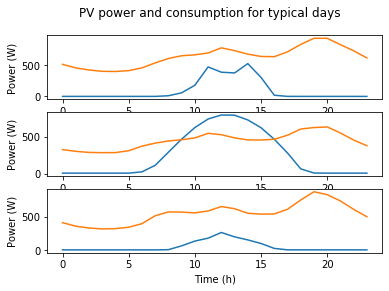

GWP = 33691.2 kg CO2 eq. / kWh
Taille des batteries : 0.0 Wh 
SCF = 0.89
Résultats pour les jours typiques, avec (surface, inclinaison, orientation) = (6.05, 30.75, 26.83)


In [88]:
from optim.optim_definition import plot_results

# plot results      
plot_results(surface=surface, tilt=tilt, azimuth=azimuth,
                             irradiance_list=irr_list, consumption_list=cons_list, 
                             typical_day_nb=typical_day_nb)
# print results
for name, value in result.rawResults.items():
#     if not (('irradiance' in name) or ('consumption' in name) or ('e_sto' in name)or ('lcf' in name) or ('nrj' in name) or ('balance' in name)):
#         print(name, '  \t =', value)
    if ('gwp' in name):
        print('GWP = {} kg CO2 eq. / kWh'.format(round(value,2)))
    if ('capa_bat' in name):
        print('Taille des batteries : {} Wh '.format(round(value,2)))
    if ('non_scf' in name):
        print('SCF = '+str(round((1-value),2)))
sta = [round(value,2) for value in [surface, tilt, azimuth]]
print('Résultats pour les jours typiques, avec (surface, inclinaison, orientation) = ({0}, {1}, {2})'.format(*sta))

<span style="color:red"> ***TODO***</span> : Observez les résultats pour chaque objectif :
1. Comment interpréter les résultats dans chacun des cas ? 
2. Quelles différence observez-vous ?

BONUS : essayez d'entrer l'objectif d'autoproduction ('non_lcf') : cet objectif ne va pas chercher à minimiser les exports sur le réseau mais uniquement les imports. Qu'observez-vous ?

## Limites de l'approche

Les résultats obtenus ici ne doivent en aucun cas être pris pour généralités : ils correspondent à des choix de données et de modélisation qui doivent être confrontés à d'autres études (et à votre esprit critique). Différentes limites peuvent être soulignées sur notre approche.

Le modèle énergétique est ici très simplifié : un calcul dynamique des puissances du stockage pourrait être réalisé pour refléter plus finement le fonctionnement et le pilotage du stockage. Cela permettrait en plus d’intégrer la dynamique des émissions de CO2 du réseau et d’observer le détail des flux de puissance à chaque pas de temps, améliorant ainsi la compréhension générale du système énergétique.  

De plus des hypothèses de modélisation plus fines pourront être adoptées sur les 30 années considérées, comme le vieillissement des batteries et panneaux PV ou l’évolution des mix énergétiques. En outre une partie des profils de consommation pourrait être pilotables pour refléter une éventuelle adaptation de la consommation à la production locale. Le principe des jours types pourrait aussi être affiné pour gagner en représentativité.

Enfin il serait intéressant de mener l’étude à l’échelle quartier afin de qualifier et quantifier les conséquences sur le réseau électrique, et d’évaluer la pertinence du dimensionnement avec les indicateurs présentés ici. Une perspective envisagée est également d’étendre ce cas d’étude à l’échelle d’opérations d’autoconsommation collective pour intégrer des enjeux de communautés énergétiques.

Pour ce qui est de la méthode et des données utilisée pour l’ACV, le GWP a été choisi ici car il s’agit d’un indicateur accessible et directement lié au dérèglement climatique, mais la considération d’autres impacts environnementaux comme l’acidification des sols et de l'eau ou l’épuisement de ressources non-renouvelables serait pertinente pour disposer d’une vision plus complète. Une des difficultés principales concernant l’ACV ouverte reste l’accès aux données et outils, et la variabilité des données : sur le seul indicateur de GWP des panneaux PV monocristallins, les écarts entre les valeurs issues de différentes sources fiables dépassent le facteur 3. Outre le fait que le calcul d’émissions de GES de modules photovoltaïques dépende d’un nombre important de facteurs, cette variabilité peut s’expliquer d’une part par la considération ou non des connectiques et onduleurs dans le calcul d’impact, et d’autre part par l’origine des panneaux PV. A ce titre, l’initiative du projet [BONSAI](https://bonsai.uno/) visant à déployer une base de donnée ouverte pour les données d’ACV est très pertinente et prometteuse.


## Perspectives
Pour ouvrir ce que peuvent donner ces travaux, deux figures en perspectives :

1. Une courbe présentant le pilotage du stockage à l'aide d'un autre outil Open Source, [OMEGAlpes](https://omegalpes.readthedocs.io/). Celle-ci peut être retrouvée sur ce [jupyter notebook](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/blob/master/notebooks/article_2021_BS_ORUCE.ipynb).
![pilotage OMEGAlpes](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/raw/master/examples/pv_battery_coverage_gwp/figures/pilotage_OMEGAlpes.png)

2. Une courbe de Pareto (c'est une courbe de compromis, où chaque point va correspondre à une optimisation entre deux objectifs) entre les objectifs de couverture locale de la consommation et émissions de gaz à effet de serre

![Pareto](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/raw/master/examples/pv_battery_coverage_gwp/figures/pareto.png)